In [282]:
import igraph as ig
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict

In [319]:
MIN_PROB = 0.90
MAX_EVAL = 1e-3
MIN_COV = 0.9

In [320]:
putative_polyproteins = {
    "AFN73048-160-772",
    "AGA82737-223-1557",
    "AII01805-1323-1950",
    "AIY25916-39-1071",
    "AJG39083-75-1055",
    "AJZ68872-213-1628",
    "AKN56871-186-1869",
    "AKN56888-187-1825",
    "AKN56890-1-1262",
    "ALD89111-54-1194",
    "ALD89111-54-1194",
    "ANW72256-210-1321",
    "APG79216-246-1777",
    "APG79216246-1777",
    "APG79225",
    "APG79225-717-2090",
    "ARF07019-184",
    "ARF07019-184-2261",
    "cluster_002482",
    "cluster_003593",
    "NP_044598-16-1180",
    "NP_049362-255-1973",
    "NP_066251-10-1089",
    "NP_573541-1-676",
    "NP_690839-1-875",
    "NP_694468-288-1197",
    "NP_694872-178-2213",
    "P35942-181-1148",
    "PF00946",
    "PF00946.21",
    "PF06317.13",
    "PR00918",
    "YP_002905337-3-1018",
    "YP_003104764-245-1674",
    "YP_003620396-1-1220",
    "YP_003934933-309-1461",
    "YP_004226522-4-1259",
    "YP_004598981-3600-4280",
    "YP_006390636-200-1050",
    "YP_009028573-1209-2746",
    "YP_009094051-171-1093",
    "YP_009182187-87-805",
    "YP_009272911-65-1157",
    "YP_009305102-50-1080",
    "YP_009330274",
    "YP_009330274-238-1037",
    "YP_009336483-1873-2859",
    "YP_009336824-5-1646",
    "YP_009362029-223-1914",
    "YP_052968-6-1302",
    "cd21530",
    "YP_002308505-4545-4591",
    "cluster_004196",
    "cluster_000913",
    "cluster_003439",
    "cluster_002083",
    "cluster_004301",
    "cluster_002164",
    "cluster_004196",
    "cluster_000913",
    "cluster_000945",
    "cluster_002691",
    "cd21593",
    "cd21588",
}

Read the tabular HHblits output and remove all the rows containing putative polyproteins.  The profile list above was generated by the get_polyproteins.ipynb notebook, then supplmented with additional problematic profiles that were manually identified.  

In [321]:
tabular_hhr = pd.read_table("test.tsv")
tabular_hhr = tabular_hhr[~(tabular_hhr['qid'].isin(putative_polyproteins) | tabular_hhr['tid'].isin(putative_polyproteins))]
tabular_hhr


qid                  tid  qlen  tlen    qcov    tcov  \
0                0034826              2adrA01    28    27  0.9286  0.9630   
1                0034826              0034826    28    27  0.9643  1.0000   
2                0034826        AMO03239-1-28    28    26  0.8929  0.9615   
3                0034826              2m9aA03    28    21  0.7500  1.0000   
4                0034826              0041429    28    30  1.0000  0.9333   
...                  ...                  ...   ...   ...     ...     ...   
349458  YP_654543-43-165     YP_654543-43-165   123   123  1.0000  1.0000   
349459  YP_654543-43-165  YP_004901704-45-167   123   121  0.9756  0.9917   
349460  YP_654543-43-165  YP_004928121-33-153   123   117  0.9431  0.9915   
349461  YP_654543-43-165                 SP24   123   152  0.9837  0.7961   
349462  YP_654543-43-165  YP_009345040-56-186   123   130  0.9106  0.8615   

       qcoord  tcoord    prob          eval   score  
0        2-27    1-27  0.9950  3.500000e-16   42.86  
1        1-27    1-27  0.9947  4.600000e-15   37.37  
2        4-28    2-26  0.9921  4.900000e-13   35.89  
3        4-24    1-21  0.9911  1.700000e-12   32.98  
4        1-28    3-30  0.9891  6.500000e-11   30.23  
...       ...     ...     ...           ...     ...  
349458  1-123   1-123  1.0000  1.900000e-58  338.94  
349459  1-121   1-121  1.0000  1.000000e-51  303.10  
349460  1-119   1-117  1.0000  1.500000e-50  296.29  
349461  1-121  13-152  0.9983  9.900000e-21  124.19  
349462  7-120   2-130  0.9448  5.900000e-02   36.73  

[344548 rows x 11 columns]

Identify and discard which profiles lack self hits, and thus cannot be used downstream. 

In [322]:
symetrical_profiles = tabular_hhr["qid"][tabular_hhr["qid"] == tabular_hhr["tid"]]
tabular_hhr = tabular_hhr[tabular_hhr['qid'].isin(symetrical_profiles) & tabular_hhr['tid'].isin(symetrical_profiles)]


Filter profiles whose `profile_accession` and `profile_name` got messed up.

In [323]:
# Remove profiles whose `profile_accession` and `profile_name` got messed up.
all_profile_accessions =  open('all_profile_accessions.lst').read().split('\n')
tabular_hhr = tabular_hhr[tabular_hhr['qid'].isin(all_profile_accessions) & tabular_hhr['tid'].isin(all_profile_accessions)]
#"Pdase_C33_assoc" in set(tabular_hhr['qid'])

Next, store all profiles in the `all_nodes` object (to make sure that no profile is left out of the clustering) and all the self-hit scores in the `self_hit_score` dictionary. 


In [324]:
# The `contains_polyprotein` list will be a column in the DataFrame and will store
# the information of whether the row's query or target are putative polyproteins.
contains_polyprotein = []
# The `self_hit_score` dictionary will store the scores of all the self-hits.
self_hit_score = {}
for row in tabular_hhr.iterrows():
    # Skip putative polyproteins.
    if row[1]["qid"] in putative_polyproteins or row[1]["tid"] in putative_polyproteins:
        contains_polyprotein.append(True)
    else:
        contains_polyprotein.append(False)
    # Record the self-hit scores.
    if row[1]["qid"] == row[1]["tid"]:
        self_hit_score[row[1]["qid"]] = row[1]["score"]
tabular_hhr = tabular_hhr.loc[[not i for i in contains_polyprotein]]
# Create the `all_nodes` list before filtering the table to make sure that all
# profiles will be in the network.
all_nodes = tabular_hhr.loc[:,"qid"].values.tolist() + tabular_hhr.loc[:,"tid"].values.tolist()
all_nodes = list(set(all_nodes))

Filter the matches by probability (`MIN_PROB`), E-value (`MAX_EVAL`), and minimum coverage (`MIN_COV`).

In [325]:
# Filter the table using `MIN_PROB`, `MAX_EVAL`, and `MIN_COV`.
tabular_hhr = tabular_hhr.query(
    f"prob >= {MIN_PROB} & eval <= {MAX_EVAL} & (qcov >= {MIN_COV} | tcov >= {MIN_COV})"
)

Iterate through the table and store the scores of each match in the `profile_pair_scores` dictionary. The score of each match between a pair of profiles is scaled by dividing its value by the self-hit score of the first profile of the pair.
```
profile_pair_scores[(A,B)] = [score[A,B]/score[A,A], score[B,A]/score[B,B]]
```

In [326]:
profile_pair_scores = defaultdict(list)
for row in tabular_hhr.iterrows():
    if row[1]["qid"] != row[1]["tid"]:
        pair = tuple(sorted([row[1]["qid"], row[1]["tid"]]))
        scaled_score = row[1]["score"] / self_hit_score[row[1]["qid"]]
        profile_pair_scores[pair].append(scaled_score)

Next, the `edge_list` and the `weight_list` lists are created to store the network edges and their weights, respectivelly. The weight of the edge connecting two profiles is computed as:
```
weight[(A,B)] = ln(max(score[A,B]/score[A,A], score[B,A]/score[B,B]) × 100)
```
The purpose of the `× 100` scale factor is to prevent `weight[(A,B)]` from being a negative number.

In [327]:
edge_list = []
weight_list = []
for pair, scaled_scores in profile_pair_scores.items():
    edge_list.append(pair)
    edge_weight = np.log(np.max(scaled_scores) * 100)
    if edge_weight > 0:
        weight_list.append(edge_weight)

Finally, the graph object (`profile_graph`) is created and communities are detected using the Leiden algorithm. The stringency of the algorithm is controlled by the resolution parameter.

Text(0, 0.5, 'Number of communities')

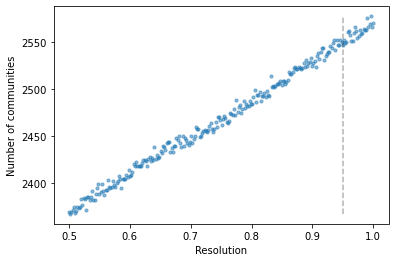

In [328]:
profile_graph = ig.Graph()
profile_graph.add_vertices(all_nodes)
profile_graph.add_edges(edge_list, attributes={"weight": weight_list})
community_sizes = []
# Iterate through multiple resolutions and store the number of communities.
for res in np.linspace(0.50, 1, 250):
    lc = profile_graph.community_leiden(resolution_parameter=res, weights="weight")
    community_sizes.append(len(lc))
# Plot how the total number of communities change according to the resolution.
plt.vlines(0.95, min(community_sizes), max(community_sizes), ls="--", color="k", alpha=0.3)
plt.scatter(np.linspace(0.50, 1, 250), community_sizes, s=10, alpha=0.5)
plt.xlabel("Resolution")
plt.ylabel("Number of communities")

We decided to set the resolution parameter tbetween `[0.95,0.99]`, resulting in smaller and more connected communities. The detected communities (clans, herafter) are saved to the `clan_membership.txt` file.

In [329]:
lc = profile_graph.community_leiden(resolution_parameter=0.99, weights="weight")
with open("clan_membership.txt", "w") as fout:
    for community in lc.subgraphs():
        line = ",".join(i.attributes()["name"] for i in community.vs)
        fout.write(f"{line}\n")